# Must-visit places for foodies in european capitals

Capstone Project - The Battle of the Neighborhoods

Aim: look for food-related venues with particular restaurants in the capitals of European countries, cluster them and ultimately reveal the different cities in terms of food venues, even if they have closer geography

### Index

1. Notes on the datasets


2. Download all the dependencies we may need and import packages


3. Data cleaning

#### 1. Notes on the datasets

To explore this topic, we will need 2 datasets: 

1) one of them contain the coordinates of the european capital cities, available on:
http://techslides.com/list-of-countries-and-capitals
(we only considered the countries that are listed as "Sovereign states" in this webpage https://en.wikipedia.org/wiki/Category:Capitals_in_Europe)


2) acquired location data to explore the nearby restaurant venues from the Foursquare API. Using the "explore" option, we look for top 10 food venues in 500 m radius for each city center and we get "Venue", "Venue Latitude", "Venue Longitude" and "Venue Category"

#### 2. Download all the dependencies we may need and import packages

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
# convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize 
# tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium 
# map rendering library

print('Libraries imported.')


Libraries imported.


#### 3. Data cleaning

##### 3.1 Using read_html from pandas to read in tables from a html; get a dataframe (df)

In [2]:
raw_data = pd.read_html("http://techslides.com/list-of-countries-and-capitals", header = 0)
# determine the index of raw_data
# raw_data = raw_data[0]

# Looks like that our table of interest is the first element in the list "raw_data" where we scraped the data to. 
# So, let's create a data frame from that element
df = pd.DataFrame(raw_data[0]) 
print(df.shape)
df.head() # check the first 5 rows

(245, 6)


,Country Name,Capital Name,Capital Latitude,Capital Longitude,Country Code,Continent Name
0,Afghanistan,Kabul,34.516667,69.183333,AF,Asia
1,Aland Islands,Mariehamn,60.116667,19.900000,AX,Europe
2,Albania,Tirana,41.316667,19.816667,AL,Europe
3,Algeria,Algiers,36.750000,3.050000,DZ,Africa
4,American Samoa,Pago Pago,-14.266667,-170.700000,AS,Australia


##### 3.2 Filter the data for the European Continent

In [3]:
# df contains all the world capitals. Let's filter the data only for European continent
# filter the dataframe to have 'Continent Name' that contains 'Europe'
filter_europe = df[df['Continent Name'].str.contains("Europe")].reset_index(drop=True)
print(filter_europe.shape)
filter_europe.head()

(58, 6)


,Country Name,Capital Name,Capital Latitude,Capital Longitude,Country Code,Continent Name
0,Aland Islands,Mariehamn,60.116667,19.900000,AX,Europe
1,Albania,Tirana,41.316667,19.816667,AL,Europe
2,Andorra,Andorra la Vella,42.500000,1.516667,AD,Europe
3,Armenia,Yerevan,40.166667,44.500000,AM,Europe
4,Austria,Vienna,48.200000,16.366667,AT,Europe


##### 3.3 Filter the data to contain only European Sovereigh States

In [4]:
# we considered only the countries in the dataframe that are considered sovereign states, according to https://en.wikipedia.org/wiki/Category:Capitals_in_Europe
# So, let's remove the States with limited recognition, dependencies and other entities

list_of_others = ['Abkhazia','Artsakh','Kosovo', 'Northern Cyprus', 'South Ossetia', 'Transnistria', 'Aland Islands', 'Faroe Islands', 'Gibraltar', 'Guernsey', 'Isle of Man', 'Jersey', 'Svalbard']
df_final = filter_europe[~filter_europe['Country Name'].isin(list_of_others)]
df_final = pd.DataFrame(df_final).reset_index(drop=True)
print(df_final.shape)
df_final.head()

(49, 6)


,Country Name,Capital Name,Capital Latitude,Capital Longitude,Country Code,Continent Name
0,Albania,Tirana,41.316667,19.816667,AL,Europe
1,Andorra,Andorra la Vella,42.500000,1.516667,AD,Europe
2,Armenia,Yerevan,40.166667,44.500000,AM,Europe
3,Austria,Vienna,48.200000,16.366667,AT,Europe
4,Azerbaijan,Baku,40.383333,49.866667,AZ,Europe


##### 3.4 Visualise the map of the European Capitals considered

In [5]:
# Visualise the European capitals
# create map using latitude and longitude values
latitude = df_final.loc[0, 'Capital Latitude']
longitude = df_final.loc[0, 'Capital Longitude']
map_europe = folium.Map(location=[latitude, longitude], zoom_start=2.5)

# add markers to map
for lat, lng, label in zip(df_final['Capital Latitude'], df_final['Capital Longitude'], df_final['Capital Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_europe)  
#print('Latitude and longitude values of Toronto are {}, {}.'.format(latitude, 
                                                              # longitude))    
map_europe

#### 4. Acquired location data to explore the nearby restaurant venues from the Foursquare API

##### 4.1 Setting Foursquare Credentials and Version

In [62]:
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXX
CLIENT_SECRET:XXX


##### 4.2 Create the GET request URL to search for Venue with requested 'Section' as 'Food'

In [7]:
def getNearbyFood(names, latitudes, longitudes, radius=500, LIMIT=15):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Capital Name', 
                  'Capital Latitude', 
                  'Capital Longitude',            
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',         
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

We need to use 'pickle' library to serialize the information retrieved from GET requests. This step will count any redundant requests to the Foursquare API.

In [8]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('europe_food_.pkl', 'rb') as f:
        europe_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    europe_venues = getNearbyFood(names=df_final['Capital Name'],
                                    latitudes = df_final['Capital Latitude'],
                                    longitudes=df_final['Capital Longitude']
                                       )
    with open('europe_food_.pkl', 'wb') as f:
        pickle.dump(europe_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


In [9]:
# check the size of the resulting dataframe and check the first 5 rows
print(europe_venues.shape)
europe_venues

(641, 7)


,Capital Name,Capital Latitude,Capital Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tirana,41.316667,19.816667,Sophie Caffe & Snacks,41.318426,19.814562,Coffee Shop
1,Tirana,41.316667,19.816667,Era Restaurant & Pizzeria,41.320253,19.814534,Pizza Place
2,Tirana,41.316667,19.816667,Sophie Caffe & Snacks,41.317183,19.818986,Café
3,Tirana,41.316667,19.816667,D'angelo coffee shop,41.319406,19.818964,Coffee Shop
4,Tirana,41.316667,19.816667,Hotel Dinasty,41.314882,19.812469,Bed & Breakfast
5,Tirana,41.316667,19.816667,Artigiano,41.319398,19.818842,Italian Restaurant
6,Tirana,41.316667,19.816667,SALT,41.321630,19.817421,Bistro
7,Tirana,41.316667,19.816667,Caffé Vergnano,41.321447,19.817820,Café
8,Tirana,41.316667,19.816667,Mystic2 Bar Restaurant,41.319848,19.814208,Restaurant
9,Tirana,41.316667,19.816667,Çoko,41.321535,19.816496,Bistro


In [10]:
print('There are {} unique venues \n {} total venues and \n {} unique categories. \n So, we have repeated venues!'.format(len(europe_venues['Venue'].unique()), len(europe_venues['Venue']), len(europe_venues['Venue Category'].unique())))

There are 621 unique venues 
 641 total venues and 
 102 unique categories. 
 So, we have repeated venues!


In [11]:
#print('There are {} uniques categories.'.format(len(europe_venues['Venue Category'].unique())))
#europe_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

In [12]:
# list all the categories
#unique_categories = europe_venues['Venue Category'].unique().tolist()
#print(', '.join(str(x) for x in unique_categories))

In [13]:
# manually create a list of generalized categories
#general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
#                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
#                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
#                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
#                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
#                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
#                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
#                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
#                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
#                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
#                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
#                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',#
#                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
#                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
#                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
#                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [14]:
# fetch all the required food categories
#food_categories =  list(set(unique_categories) - set(general_categories))
#print(', '.join(str(x) for x in food_categories))

In [15]:
# Let's remove all the generalized categories, like Coffee Shop, Cafe, etc.

#europe_venues = europe_venues[europe_venues['Venue Category'].isin(food_categories)].reset_index()
#europe_venues.head(5)



In [16]:
#print('There are {} unique venues \n {} total venues and \n {} unique categories. \n So, we have repeated venues!'.format(len(europe_venues['Venue'].unique()), len(europe_venues['Venue']), len(europe_venues['Venue Category'].unique())))

So, let's drop out the duplicated venues

In [17]:
europe_venues = europe_venues.drop_duplicates('Venue')
print('We now have {} total venues'.format(len(europe_venues['Venue'])))

We now have 621 total venues


 #### 5. Analyse Each European Capital

In [18]:
# one hot encoding
europe_onehot = pd.get_dummies(europe_venues[['Venue Category']], prefix="", prefix_sep="")

# add capital name column back to dataframe
europe_onehot['Capital Name'] = europe_venues['Capital Name'] 

# move capital name column to the first column
fixed_columns = [europe_onehot.columns[-1]] + list(europe_onehot.columns[:-1])
europe_onehot = europe_onehot[fixed_columns]

europe_onehot.head()

,Capital Name,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Brasserie,Bratwurst Joint,Breakfast Spot,Brewery,Buffet,Bulgarian Restaurant,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant,Deli / Bodega,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,English Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Food Court,Food Truck,French Restaurant,Gastropub,General Entertainment,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,Other Nightlife,Pastry Shop,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,South American Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Tirana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Tirana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Tirana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tirana,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Tirana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# examine the new dataframe size
europe_onehot.shape

(621, 103)

In [20]:
# Let's count venues of each category in each capital
venue_counts = europe_onehot.groupby('Capital Name').sum()
venue_counts.head(5)
# Let's find out the top 10 food categories in European capitals
venue_counts_described = venue_counts.describe().transpose()
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Café,48.0,1.833333,1.860374,0.0,0.0,1.5,3.00,8.0
Italian Restaurant,48.0,0.541667,1.071057,0.0,0.0,0.0,1.00,5.0
Coffee Shop,48.0,1.145833,1.352532,0.0,0.0,1.0,2.00,5.0
Restaurant,48.0,1.208333,1.147770,0.0,0.0,1.0,2.00,5.0
Japanese Restaurant,48.0,0.145833,0.618495,0.0,0.0,0.0,0.00,4.0
Fast Food Restaurant,48.0,0.250000,0.635811,0.0,0.0,0.0,0.00,3.0
Spanish Restaurant,48.0,0.062500,0.433013,0.0,0.0,0.0,0.00,3.0
Tea Room,48.0,0.145833,0.504852,0.0,0.0,0.0,0.00,3.0
Pizza Place,48.0,0.500000,0.771845,0.0,0.0,0.0,1.00,3.0
Ice Cream Shop,48.0,0.333333,0.663111,0.0,0.0,0.0,0.25,3.0


In [21]:
venue_top10_list = venue_top10.index.values.tolist()

In [22]:
#import seaborn as sns
#import matplotlib.pyplot as plt

#fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
#axes = axes.flatten()

#for ax, category in zip(axes, venue_top10_list):
#    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
#    pal = sns.color_palette("Blues", len(data))
#    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

#plt.tight_layout()
#plt.show();

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
europe_grouped = europe_onehot.groupby('Capital Name').mean().reset_index()
europe_grouped

,Capital Name,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Brasserie,Bratwurst Joint,Breakfast Spot,Brewery,Buffet,Bulgarian Restaurant,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant,Deli / Bodega,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,English Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Food Court,Food Truck,French Restaurant,Gastropub,General Entertainment,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,Other Nightlife,Pastry Shop,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,South American Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Amsterdam,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Andorra la Vella,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Ankara,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.533333,0.000000,0.000000,0.066667,0.000000,0.000000,0.133333,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [24]:
# confirm the new size

europe_grouped.shape

(48, 103)

In [25]:
# Let's print each capital along with the top 10 most common venues

num_top_venues = 10

for hood in europe_grouped['Capital Name']:
    print("----"+hood+"----")
    temp = europe_grouped[europe_grouped['Capital Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amsterdam----
                   venue  freq
0             Restaurant  0.20
1                   Café  0.20
2            Coffee Shop  0.13
3      French Restaurant  0.07
4            Pizza Place  0.07
5         Breakfast Spot  0.07
6         Ice Cream Shop  0.07
7                  Hotel  0.07
8     Italian Restaurant  0.07
9  Australian Restaurant  0.07


----Andorra la Vella----
                   venue  freq
0             Restaurant  0.27
1            Coffee Shop  0.13
2  Portuguese Restaurant  0.13
3                  Diner  0.13
4                 Bakery  0.07
5                   Café  0.07
6            Snack Place  0.07
7         Breakfast Spot  0.07
8              BBQ Joint  0.07
9       Kebab Restaurant  0.00


----Ankara----
                     venue  freq
0                     Café  0.53
1              Coffee Shop  0.13
2         Kebab Restaurant  0.07
3  Comfort Food Restaurant  0.07
4                 Tea Room  0.07
5           Chocolate Shop  0.07
6               Steakhous

In [26]:
# First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Capital Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
europe_venues_sorted = pd.DataFrame(columns=columns)
europe_venues_sorted['Capital Name'] = europe_grouped['Capital Name']

for ind in np.arange(europe_grouped.shape[0]):
    europe_venues_sorted.iloc[ind, 1:] = return_most_common_venues(europe_grouped.iloc[ind, :], num_top_venues)

europe_venues_sorted



,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amsterdam,Restaurant,Café,Coffee Shop,Ice Cream Shop,Pizza Place,Italian Restaurant,Breakfast Spot,Australian Restaurant,Hotel,French Restaurant
1,Andorra la Vella,Restaurant,Portuguese Restaurant,Coffee Shop,Diner,Café,Breakfast Spot,BBQ Joint,Bakery,Snack Place,Clothing Store
2,Ankara,Café,Coffee Shop,Tea Room,Chocolate Shop,Comfort Food Restaurant,Kebab Restaurant,Steakhouse,Fast Food Restaurant,Falafel Restaurant,General Entertainment
3,Athens,Coffee Shop,Café,Dessert Shop,Bar,Souvlaki Shop,Sushi Restaurant,Restaurant,Other Nightlife,Wine Bar,Vegetarian / Vegan Restaurant
4,Baku,Tea Room,Café,Restaurant,Seafood Restaurant,Modern European Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Eastern European Restaurant,Afghan Restaurant,Diner
5,Belgrade,Restaurant,Seafood Restaurant,Wings Joint,Doner Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant
6,Berlin,Café,German Restaurant,Salad Place,Thai Restaurant,Seafood Restaurant,Brewery,Steakhouse,Bakery,Diner,Restaurant
7,Bern,Japanese Restaurant,Wings Joint,Eastern European Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant,Deli / Bodega,Dessert Shop
8,Bratislava,Café,Coffee Shop,Brewery,Vegetarian / Vegan Restaurant,Greek Restaurant,Burger Joint,Taco Place,Breakfast Spot,Bistro,Donut Shop
9,Brussels,Coffee Shop,Greek Restaurant,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Deli / Bodega,Taco Place,Food Court,Ice Cream Shop,Vegetarian / Vegan Restaurant


#### Cluster European Capitals

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 

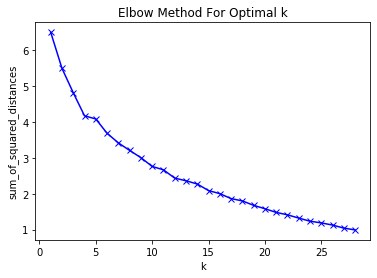

In [28]:
# Determine the optimal number of clusters for k-means clustering

europe_grouped_clustering = europe_grouped.drop('Capital Name', 1)

sum_of_squared_distances = []
K = range(1,29)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(europe_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [29]:
#from sklearn.metrics import silhouette_score

#sil = []
#K_sil = range(2,40)
## minimum 2 clusters required, to define dissimilarity
#for k in K_sil:
#    print(k, end=' ')
#    kmeans = KMeans(n_clusters = k).fit(europe_grouped_clustering)
#    labels = kmeans.labels_
#    sil.append(silhouette_score(europe_grouped_clustering, labels, metric = 'euclidean'))
    
#plt.plot(K_sil, sil, 'bx-')
#plt.xlabel('k')
#plt.ylabel('silhouette_score')
#plt.title('Silhouette Method For Optimal k')
#plt.show()

In [30]:
# We ser the number of clusters in k = 9, following the "Elbow method"

# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(europe_grouped_clustering)


In [31]:
# add clustering labels
try:
    europe_venues_sorted.drop('Cluster Labels', axis=1)
except:
    europe_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [32]:
europe_venues_sorted

,Cluster Labels,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,Amsterdam,Restaurant,Café,Coffee Shop,Ice Cream Shop,Pizza Place,Italian Restaurant,Breakfast Spot,Australian Restaurant,Hotel,French Restaurant
1,0,Andorra la Vella,Restaurant,Portuguese Restaurant,Coffee Shop,Diner,Café,Breakfast Spot,BBQ Joint,Bakery,Snack Place,Clothing Store
2,2,Ankara,Café,Coffee Shop,Tea Room,Chocolate Shop,Comfort Food Restaurant,Kebab Restaurant,Steakhouse,Fast Food Restaurant,Falafel Restaurant,General Entertainment
3,0,Athens,Coffee Shop,Café,Dessert Shop,Bar,Souvlaki Shop,Sushi Restaurant,Restaurant,Other Nightlife,Wine Bar,Vegetarian / Vegan Restaurant
4,4,Baku,Tea Room,Café,Restaurant,Seafood Restaurant,Modern European Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Eastern European Restaurant,Afghan Restaurant,Diner
5,5,Belgrade,Restaurant,Seafood Restaurant,Wings Joint,Doner Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant
6,4,Berlin,Café,German Restaurant,Salad Place,Thai Restaurant,Seafood Restaurant,Brewery,Steakhouse,Bakery,Diner,Restaurant
7,1,Bern,Japanese Restaurant,Wings Joint,Eastern European Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant,Deli / Bodega,Dessert Shop
8,2,Bratislava,Café,Coffee Shop,Brewery,Vegetarian / Vegan Restaurant,Greek Restaurant,Burger Joint,Taco Place,Breakfast Spot,Bistro,Donut Shop
9,0,Brussels,Coffee Shop,Greek Restaurant,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Deli / Bodega,Taco Place,Food Court,Ice Cream Shop,Vegetarian / Vegan Restaurant


In [33]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
europe_merged = europe_venues_sorted.join(df_final.set_index('Capital Name'), on='Capital Name')
europe_merged.head()

,Cluster Labels,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Country Name,Capital Latitude,Capital Longitude,Country Code,Continent Name
0,4,Amsterdam,Restaurant,Café,Coffee Shop,Ice Cream Shop,Pizza Place,Italian Restaurant,Breakfast Spot,Australian Restaurant,Hotel,French Restaurant,Netherlands,52.350000,4.916667,NL,Europe
1,0,Andorra la Vella,Restaurant,Portuguese Restaurant,Coffee Shop,Diner,Café,Breakfast Spot,BBQ Joint,Bakery,Snack Place,Clothing Store,Andorra,42.500000,1.516667,AD,Europe
2,2,Ankara,Café,Coffee Shop,Tea Room,Chocolate Shop,Comfort Food Restaurant,Kebab Restaurant,Steakhouse,Fast Food Restaurant,Falafel Restaurant,General Entertainment,Turkey,39.933333,32.866667,TR,Europe
3,0,Athens,Coffee Shop,Café,Dessert Shop,Bar,Souvlaki Shop,Sushi Restaurant,Restaurant,Other Nightlife,Wine Bar,Vegetarian / Vegan Restaurant,Greece,37.983333,23.733333,GR,Europe
4,4,Baku,Tea Room,Café,Restaurant,Seafood Restaurant,Modern European Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Eastern European Restaurant,Afghan Restaurant,Diner,Azerbaijan,40.383333,49.866667,AZ,Europe


Let's visualise the resulting clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=2.5)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(europe_merged['Capital Latitude'], europe_merged['Capital Longitude'], europe_merged['Capital Name'], europe_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Results

In [49]:
required_column_indices = [1,2,3]
required_column = [list(europe_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [1,2,3]

##### Cluster 0

In [50]:
cluster_0 = europe_merged.loc[europe_merged['Cluster Labels'] == 0, europe_merged.columns[1:12]]
cluster_0.head(5)

,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Andorra la Vella,Restaurant,Portuguese Restaurant,Coffee Shop,Diner,Café,Breakfast Spot,BBQ Joint,Bakery,Snack Place,Clothing Store
3,Athens,Coffee Shop,Café,Dessert Shop,Bar,Souvlaki Shop,Sushi Restaurant,Restaurant,Other Nightlife,Wine Bar,Vegetarian / Vegan Restaurant
9,Brussels,Coffee Shop,Greek Restaurant,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Deli / Bodega,Taco Place,Food Court,Ice Cream Shop,Vegetarian / Vegan Restaurant
10,Bucharest,Coffee Shop,Romanian Restaurant,Doner Restaurant,Gastropub,Restaurant,BBQ Joint,Roof Deck,Pizza Place,Dessert Shop,Chocolate Shop
14,Dublin,Coffee Shop,Café,Restaurant,Gastropub,Asian Restaurant,Cafeteria,Indian Restaurant,Thai Restaurant,Butcher,Doner Restaurant


In [51]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Brussels            1
Kyiv                1
Bucharest           1
Athens              1
Dublin              1
Tallinn             1
Lisbon              1
Tbilisi             1
Madrid              1
Skopje              1
Riga                1
Nicosia             1
Andorra la Vella    1
London              1
Valletta            1
Name: Capital Name, dtype: int64
---------------------------------------------
Coffee Shop              7
Restaurant               4
Sandwich Place           1
Cocktail Bar             1
Portuguese Restaurant    1
Spanish Restaurant       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Café                     3
Romanian Restaurant      1
Greek Restaurant         1
Portuguese Restaurant    1
Bakery                   1
Bar                      1
English Restaurant       1
Thai Restaurant          1
Coffee Shop              1
Chinese Restaurant       1
Tapas Restaurant         1
Dessert Shop             1
Indian Restaurant

##### Cluster 1

In [52]:
cluster_1 = europe_merged.loc[europe_merged['Cluster Labels'] == 1, europe_merged.columns[1:12]]
cluster_1.head(5)

,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bern,Japanese Restaurant,Wings Joint,Eastern European Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant,Deli / Bodega,Dessert Shop


In [53]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Bern    1
Name: Capital Name, dtype: int64
---------------------------------------------
Japanese Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Wings Joint    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


##### Cluster 2

In [54]:
cluster_2 = europe_merged.loc[europe_merged['Cluster Labels'] == 2, europe_merged.columns[1:12]]
cluster_2.head(5)

,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Ankara,Café,Coffee Shop,Tea Room,Chocolate Shop,Comfort Food Restaurant,Kebab Restaurant,Steakhouse,Fast Food Restaurant,Falafel Restaurant,General Entertainment
8,Bratislava,Café,Coffee Shop,Brewery,Vegetarian / Vegan Restaurant,Greek Restaurant,Burger Joint,Taco Place,Breakfast Spot,Bistro,Donut Shop
15,Helsinki,Café,Food Court,Wings Joint,Bar,Clothing Store,Coffee Shop,Salad Place,Lebanese Restaurant,Bistro,Pizza Place
27,Paris,Japanese Restaurant,Café,Italian Restaurant,Vietnamese Restaurant,Udon Restaurant,Ramen Restaurant,Tea Room,Doner Restaurant,Chocolate Shop,Clothing Store
28,Podgorica,Café,Italian Restaurant,Bakery,Fast Food Restaurant,Gluten-free Restaurant,BBQ Joint,Dessert Shop,Donut Shop,Cocktail Bar,Coffee Shop


In [55]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Vienna        1
Podgorica     1
Helsinki      1
Ankara        1
Bratislava    1
Paris         1
Name: Capital Name, dtype: int64
---------------------------------------------
Café                   5
Japanese Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Coffee Shop           2
Italian Restaurant    1
Café                  1
Bar                   1
Food Court            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


##### Cluster 3

In [56]:
cluster_3 = europe_merged.loc[europe_merged['Cluster Labels'] == 3, europe_merged.columns[1:12]]
cluster_3.head(5)

,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Chisinau,Pizza Place,Romanian Restaurant,Burger Joint,Italian Restaurant,Wings Joint,Doner Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant
13,Copenhagen,Bakery,Sandwich Place,Italian Restaurant,Event Space,Salad Place,Sushi Restaurant,Restaurant,Scandinavian Restaurant,Coffee Shop,Ice Cream Shop
20,Luxembourg,Italian Restaurant,Pizza Place,Restaurant,Salad Place,Coffee Shop,Moroccan Restaurant,Indian Restaurant,Café,Asian Restaurant,French Restaurant
39,Tirana,Coffee Shop,Pizza Place,Bistro,Italian Restaurant,American Restaurant,Café,Ice Cream Shop,Restaurant,Bed & Breakfast,Wings Joint
42,Vatican City,Italian Restaurant,Café,Pizza Place,Diner,Ice Cream Shop,Restaurant,Sandwich Place,Deli / Bodega,Dessert Shop,Chocolate Shop


In [57]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Vatican City    1
Luxembourg      1
Chisinau        1
Tirana          1
Copenhagen      1
Name: Capital Name, dtype: int64
---------------------------------------------
Italian Restaurant    2
Bakery                1
Coffee Shop           1
Pizza Place           1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place            2
Romanian Restaurant    1
Café                   1
Sandwich Place         1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


##### Cluster 4

In [58]:
cluster_4 = europe_merged.loc[europe_merged['Cluster Labels'] == 4, europe_merged.columns[1:12]]
cluster_4.head(5)

,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amsterdam,Restaurant,Café,Coffee Shop,Ice Cream Shop,Pizza Place,Italian Restaurant,Breakfast Spot,Australian Restaurant,Hotel,French Restaurant
4,Baku,Tea Room,Café,Restaurant,Seafood Restaurant,Modern European Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Eastern European Restaurant,Afghan Restaurant,Diner
6,Berlin,Café,German Restaurant,Salad Place,Thai Restaurant,Seafood Restaurant,Brewery,Steakhouse,Bakery,Diner,Restaurant
11,Budapest,Fast Food Restaurant,Jewish Restaurant,Bakery,Ramen Restaurant,Restaurant,Coffee Shop,Comfort Food Restaurant,Kebab Restaurant,Donut Shop,Pizza Place
18,Ljubljana,Café,Pizza Place,Restaurant,Chinese Restaurant,BBQ Joint,Fast Food Restaurant,Burger Joint,Meze Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot


In [59]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Zagreb       1
Oslo         1
Amsterdam    1
Ljubljana    1
Reykjavik    1
Minsk        1
Budapest     1
Moscow       1
Rome         1
Baku         1
Stockholm    1
Berlin       1
Prague       1
Sarajevo     1
Sofia        1
Monaco       1
Yerevan      1
Warsaw       1
Name: Capital Name, dtype: int64
---------------------------------------------
Café                    9
Fast Food Restaurant    2
Bakery                  2
Restaurant              1
French Restaurant       1
Cocktail Bar            1
Food Court              1
Tea Room                1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Café                         4
Ice Cream Shop               3
Pizza Place                  2
Steakhouse                   1
Coffee Shop                  1
Italian Restaurant           1
Fast Food Restaurant         1
Bakery                       1
Jewish Restaurant            1
Restaurant                   1
German Restaurant            1
South American

##### Cluster 5

In [60]:
cluster_5 = europe_merged.loc[europe_merged['Cluster Labels'] == 5, europe_merged.columns[1:12]]
cluster_5.head(5)

,Capital Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Belgrade,Restaurant,Seafood Restaurant,Wings Joint,Doner Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant
40,Vaduz,Restaurant,Bed & Breakfast,Wings Joint,Donut Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant,Deli / Bodega
44,Vilnius,Restaurant,Pizza Place,Wings Joint,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Czech Restaurant,Deli / Bodega


In [61]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Belgrade    1
Vilnius     1
Vaduz       1
Name: Capital Name, dtype: int64
---------------------------------------------
Restaurant    3
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Seafood Restaurant    1
Pizza Place           1
Bed & Breakfast       1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
